 Copyright (c) 2015-2020, Swiss Federal Institute of Technology (ETH Zurich)

 All rights reserved.
 
 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:
 
 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.
 
 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.
 
 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.
 
 THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
 AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
 IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
 DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
 FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
 DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
 SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
 CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
 OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
 OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 

Notebook settings

In [1]:
%pylab inline
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

Populating the interactive namespace from numpy and matplotlib


Set the path to the key file and change working-directory to the root directory of the dataprocessing framework

In [2]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


# Imports

In [3]:
import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

#from copy   import copy, deepcopy   # TODO
#from pprint import pprint           # TODO

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# ExOT packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

Tensorflow not available - excluding packets using it!


# Generate Experiment
#### 1. Load config

First we can display all available channels.

In [4]:
ChannelFactory().available

[exot.channel.covertchannels.ThermalCC,
 exot.channel.covertchannels.PowerCC,
 exot.channel.covertchannels.ConservativeGovernorCC,
 exot.channel.covertchannels.FlushPrefetchCC,
 exot.channel.sidechannels.ThermalSC,
 exot.channel.covertchannels.FlushReloadCC,
 exot.channel.covertchannels.FlushFlushCC,
 exot.channel.covertchannels.CacheCC]

Load and display the TOML experiment configuration

In [5]:
config = TOML.load("./configurations/examples/demo_app_exec_experiment.toml")
print(TOML.dumps(config))

name = "demo_app_exec_experiment"
save_path = "./data"
backup_path = "./data/_backup"
experiment_exists_action = "overwrite"

[EXPERIMENT]
type = "AppExecExperiment"
channel = "ThermalSC"

[EXPERIMENT.GENERAL]
sampling_period = 0.001
delay_after_spawn = 0
delay_after_auxiliary = 0
active_wait = true

[EXPERIMENT.PHASES.test]
repetitions = 4

[EXPERIMENT.LAYERS.io]
name = "TimeValue"
synchronise = false

[ENVIRONMENTS.Z5.src]
COMPONENT_NAME = "ch.ethz.exot.intentproxy/.IntentProxyService"
ACTION = "ch.ethz.exot.intents.IntentProxy.action.BUNDLE_EXTRAS"

[ENVIRONMENTS.S5.src]
COMPONENT_NAME = "ch.ethz.exot.intentproxy/.IntentProxyService"
ACTION = "ch.ethz.exot.intents.IntentProxy.action.BUNDLE_EXTRAS"

[EXPERIMENT.PHASES.test.dropbox2]
schedules = [ "configurations/examples/RepetiTouch/Sony_Xperia_Z5_Dropbox.rpt", "configurations/examples/RepetiTouch/Samsung_Galaxy_S5_SM-900H_Dropbox.rpt",]
durations = [ 44.7, 30.3,]
environments = [ "Z5", "S5",]

[EXPERIMENT.PHASES.test.antutu3]
schedu

Generate a channel object based on the config and subsequently the experiment object.

In [6]:
channel    = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)
type(experiment) is exot.experiment.app_exec.AppExecExperiment

2020-05-22 13:27:10 :: bootstrapped layer 'io' with TimeValue


True

To avoid overwriting existing data, we change the experiment exist action parameter to update. Other options are overwrite, move and halt.

In [7]:
experiment.config.experiment_exists_action = "update"

Generate the experiment, which means populating the phases datastructures with run objects, according to the configuration of the experiment. We can print the approximate duration needed to execute the experiment and write it to the HDD using the write method.

In [8]:
experiment.generate()
experiment.print_duration()
experiment.write()

2020-05-22 13:27:11 :: Estimated duration of a single repetition of the test phase is 0:01:31.900000
2020-05-22 13:27:11 :: This results in a total estimated duration of 0:06:07.600000 for all repetitions.


We can execute all phases specified in the list in an environemnt. We can also define, whether we would like to resume the execution or start from scratch. If the resume parameter is True, ExOT will check how many log files are already present in the experiment directory and only execute the runs and execution that do not have log files.

In [24]:
experiment.execute_in_environment("Z5", ["test"], resume=True)

2020-05-22 15:12:12 :: Z5->bigLITTLE: successfully deleted remote data directory
2020-05-22 15:12:12 :: Could not delete adb-server.out22350
2020-05-22 15:12:12 :: Z5->bigLITTLE: disconnected


ExOT automatically synchronises the source and sink application traces if both applications provide log files with timestamps. As in this experiment, our source application does not provide timestamps, we have to set the io synchronise flag to False.

In [10]:
experiment.layers.io.synchronise = False

To display the measured data, we can take advatage of the ExOT plotting module.

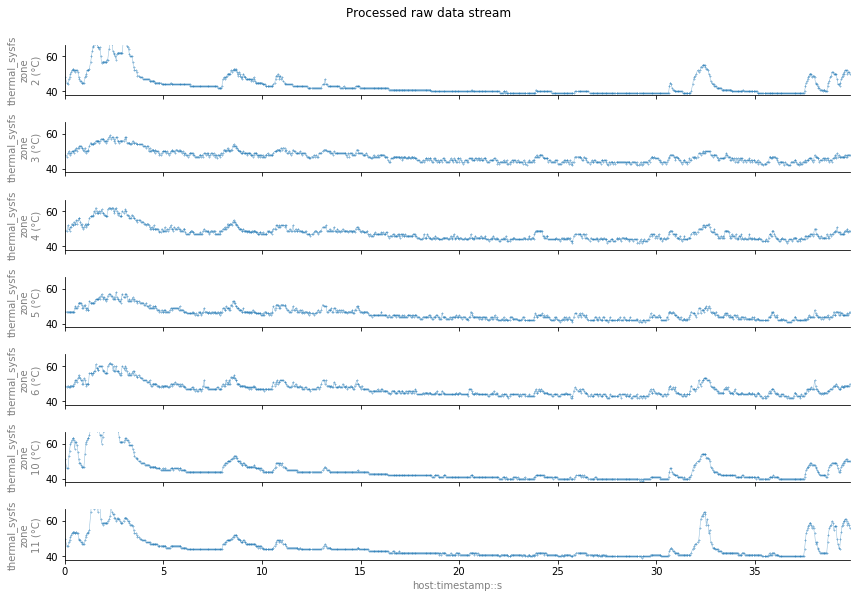

In [25]:
from exot.plotting.run_plotter import *

run = experiment.phases['test']['antutu3']
ingest_args = dict(
  io={
      "env": 'Z5', 
      "rep": 0, 
      "matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], [2,3,4,5,6,10,11]), None)]
  }
)

run.ingest(**ingest_args)

with RunPlotter(run, save_pdf=False) as plotter:
    plotter.plot_rdpstream()